## Imports

In [1]:
import wandb
import logging
from tqdm import tqdm
from wandb.sdk.wandb_run import Run
import numpy as np
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
from nn_core.common import PROJECT_ROOT
import json

/media/donato/Extra-storage/Code/model-merging/task-vector-playground-tsvmr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

In [2]:
from mass.utils.plots import Palette

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 24,        # Larger axes/title fonts
        "axes.labelsize": 24,
        "xtick.labelsize": 24,
        "ytick.labelsize": 20,
        "legend.fontsize": 24,
    }
)
sns.set_context("talk")

cmap_name = "coolwarm_r"

palette = Palette(f"{PROJECT_ROOT}/misc/palette.json", map_path=f"{PROJECT_ROOT}/misc/palette_map.json")
palette

{'blue': '#335c67',
 'white': '#fff3b0',
 'yellow': '#e09f3e',
 'red': '#9e2a2b',
 'dark red': '#540b0e',
 'green': '#81b29a'}

## Get runs

In [3]:
api = wandb.Api()
entity, project = "gladia", "task-vectors-playground"  # set to your entity and project

In [4]:
def get_runs(entity, project, positive_tags, negative_tags):
    filters_pos_tags = {"$and": [{"tags": {"$eq": pos_tag}} for pos_tag in positive_tags]}
    filters_neg_tags = {}

    print(filters_pos_tags)
    filters = {**filters_pos_tags, **filters_neg_tags}
    runs = api.runs(entity + "/" + project, filters=filters)

    print(f"There are {len(runs)} runs respecting these conditions.")
    return runs

In [5]:
tags = [
    "plotted"
]  

In [6]:
runs = get_runs(entity, project, positive_tags=tags, negative_tags=[])

{'$and': [{'tags': {'$eq': 'plotted'}}]}
There are 3 runs respecting these conditions.


In [7]:
# to access the run's config parameters, just do 
# stuff = cfg[stuff_key]

## Plot per-layer avg task accuracy

In [8]:
models = ['ViT-B-32', 'ViT-B-16', 'ViT-L-14']
datasets =  ['Cars', 'DTD', 'EuroSAT', 'GTSRB', 'MNIST', 'RESISC45', 'SUN397', 'SVHN', 'CIFAR100', 'STL10', 'Flowers102', 'OxfordIIITPet', 'PCAM', 'FER2013', 'EMNIST', 'CIFAR10', 'Food101', 'FashionMNIST', 'RenderedSST2', 'KMNIST']

#### Hparams

In [9]:
run_by_model = {}

for model in models:

    for run in runs:
        if model in run.config['core/tags']:
            run_by_model[model] = run

#### Outputs

In [10]:
run_by_model

{'ViT-B-32': <Run gladia/task-vectors-playground/qab7wz8f (finished)>,
 'ViT-B-16': <Run gladia/task-vectors-playground/sc4afc6h (finished)>,
 'ViT-L-14': <Run gladia/task-vectors-playground/kawjawzn (finished)>}

In [34]:


def get_layer_accuracies_from_run(run, ds):

    try:
        col_name = f"layer_task_accuracy/{ds}"
        df = run.history(keys=[col_name])
    except KeyError:
        print(f"No data found for {ds}")
        return None
    
    df_clean = df[col_name].dropna()
    if df_clean.shape[0] == 0:
        print(f"No data found for {ds}")
        return None 
    
    artifact_dict = df_clean.iloc[-1]
    
    if (
        isinstance(artifact_dict, dict)
        and artifact_dict.get("_type") == "plotly-file"
    ):
        artifact_path = artifact_dict["path"]
        
        artifact_file = run.file(artifact_path).download(replace=True)
        local_path = artifact_file.name

        with open(local_path, "r") as f:
            fig_dict = json.load(f)
        
        y_values = fig_dict["data"][0]["y"]  # numeric accuracies
        x_values = fig_dict["data"][0]["x"]  # layer names
        layer_names = x_values

        # remap layer_names
        layer_names = [name.replace('encoder.model.visual.transformer.resblocks.', '') for name in layer_names]
        
        return y_values, layer_names
    else:
        print(
            f"Unexpected data format for dataset '{ds}': "
            f"{artifact_dict} (not a Plotly artifact?)."
        )


def plot_task_accuracies(model, layer_accuracies, layer_names, var=None):
    # Plot
    x_indices = range(len(layer_accuracies))

    width = 24 if model == 'ViT-L-14' else 18
    plt.figure(figsize=(width, 4)) 

    if var is not None:
        bars = plt.bar(x_indices, layer_accuracies, yerr=var, color=palette["blue"], capsize=5, ecolor=palette['yellow'])
    else:
        bars = plt.bar(x_indices, layer_accuracies, color=palette["blue"])

    # Compute a y-limit with some margin for the labels
    max_height = max(layer_accuracies)
    plt.ylim(0, max_height * 1.2)

    # Put numeric labels above each bar
    plt.bar_label(bars, fmt="%.2f", label_type="edge", padding=3)

    sns.despine(offset=10, trim=True)

    ax = plt.gca()
    ax.spines['bottom'].set_bounds(min(x_indices), max(x_indices))

    if layer_names:
        plt.xticks(x_indices, layer_names, rotation=45, ha="right")

    plt.xlabel("Layer")
    plt.ylabel("Average accuracy")
    plt.tight_layout()


    plt.savefig(f"figures/{model}_layer_accuracies.pdf")
    plt.show()


def plot_model_layer_task_accuracies(run_by_model, model):

    run = run_by_model[model]
    all_layer_accuracies = []
    layer_names = None

    for ds in datasets:

        layer_accuracies, layer_names = get_layer_accuracies_from_run(run, ds)

        all_layer_accuracies.append(layer_accuracies)

    if not all_layer_accuracies:
        print("No valid layer accuracies found across the specified datasets.")
    else:
        # Convert list of lists -> shape: (num_datasets, num_layers)
        all_layer_accuracies = np.array(all_layer_accuracies)
        
        # Average across datasets (axis=0 is the layer dimension)
        avg_layer_accuracies = all_layer_accuracies.mean(axis=0)
        var = all_layer_accuracies.var(axis=0)

        plot_task_accuracies(model, avg_layer_accuracies, layer_names, var=var)



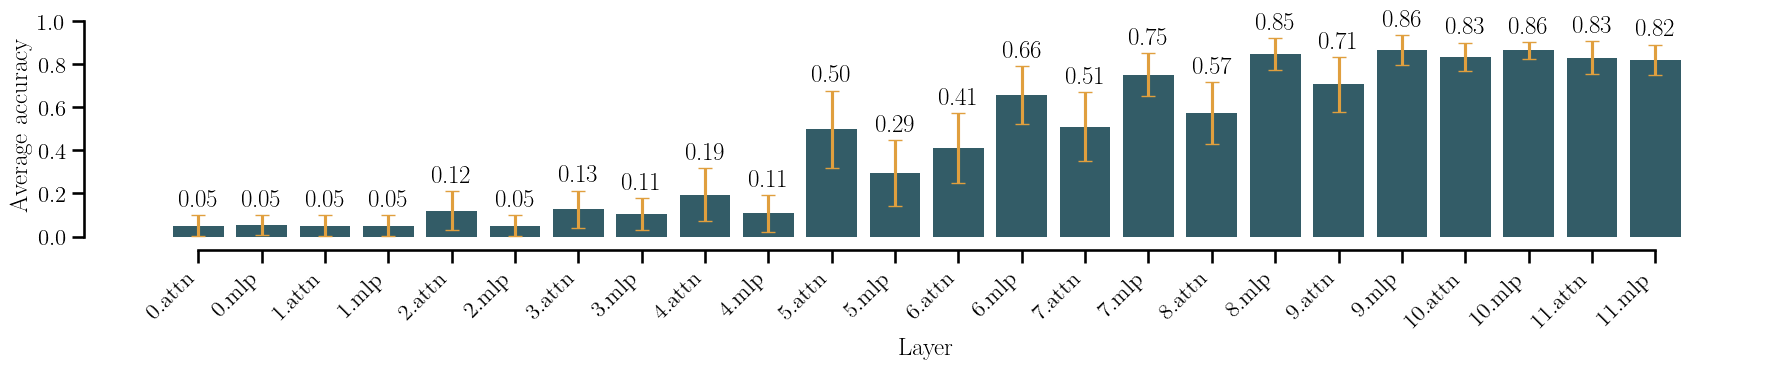

In [35]:
plot_model_layer_task_accuracies(run_by_model, 'ViT-B-32')

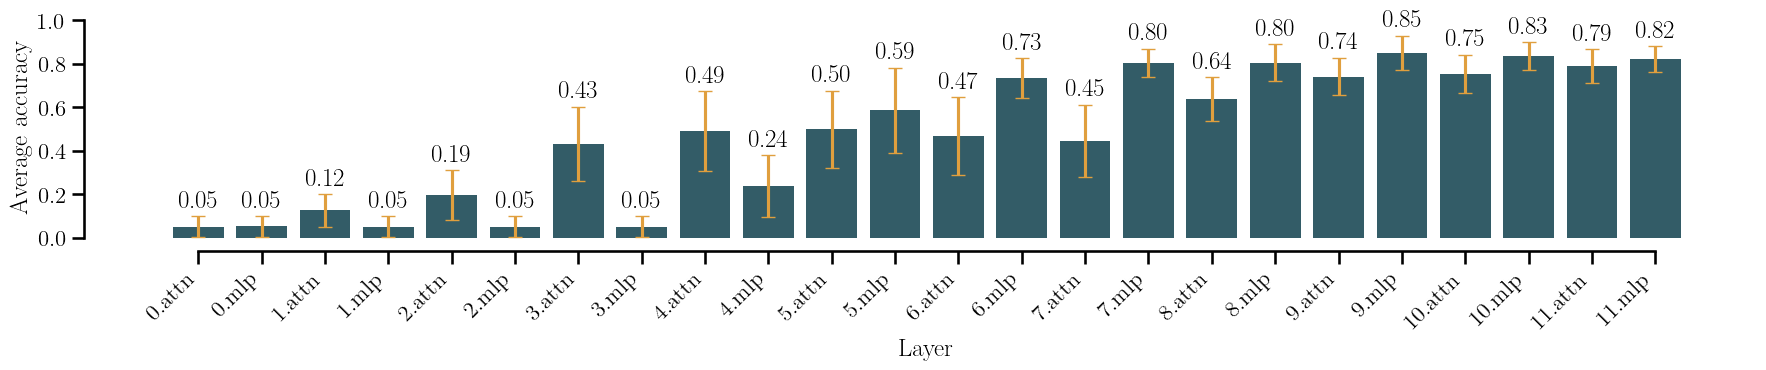

In [36]:
plot_model_layer_task_accuracies(run_by_model, 'ViT-B-16')

In [37]:
#plot_model_layer_task_accuracies(run_by_model, 'ViT-L-14')

### Plot some specific layer task accuracies

In [14]:
stl10_accs, layer_names = get_layer_accuracies_from_run(run_by_model['ViT-B-32'], 'STL10')
sun_accs, layer_names = get_layer_accuracies_from_run(run_by_model['ViT-B-32'], 'SUN397')

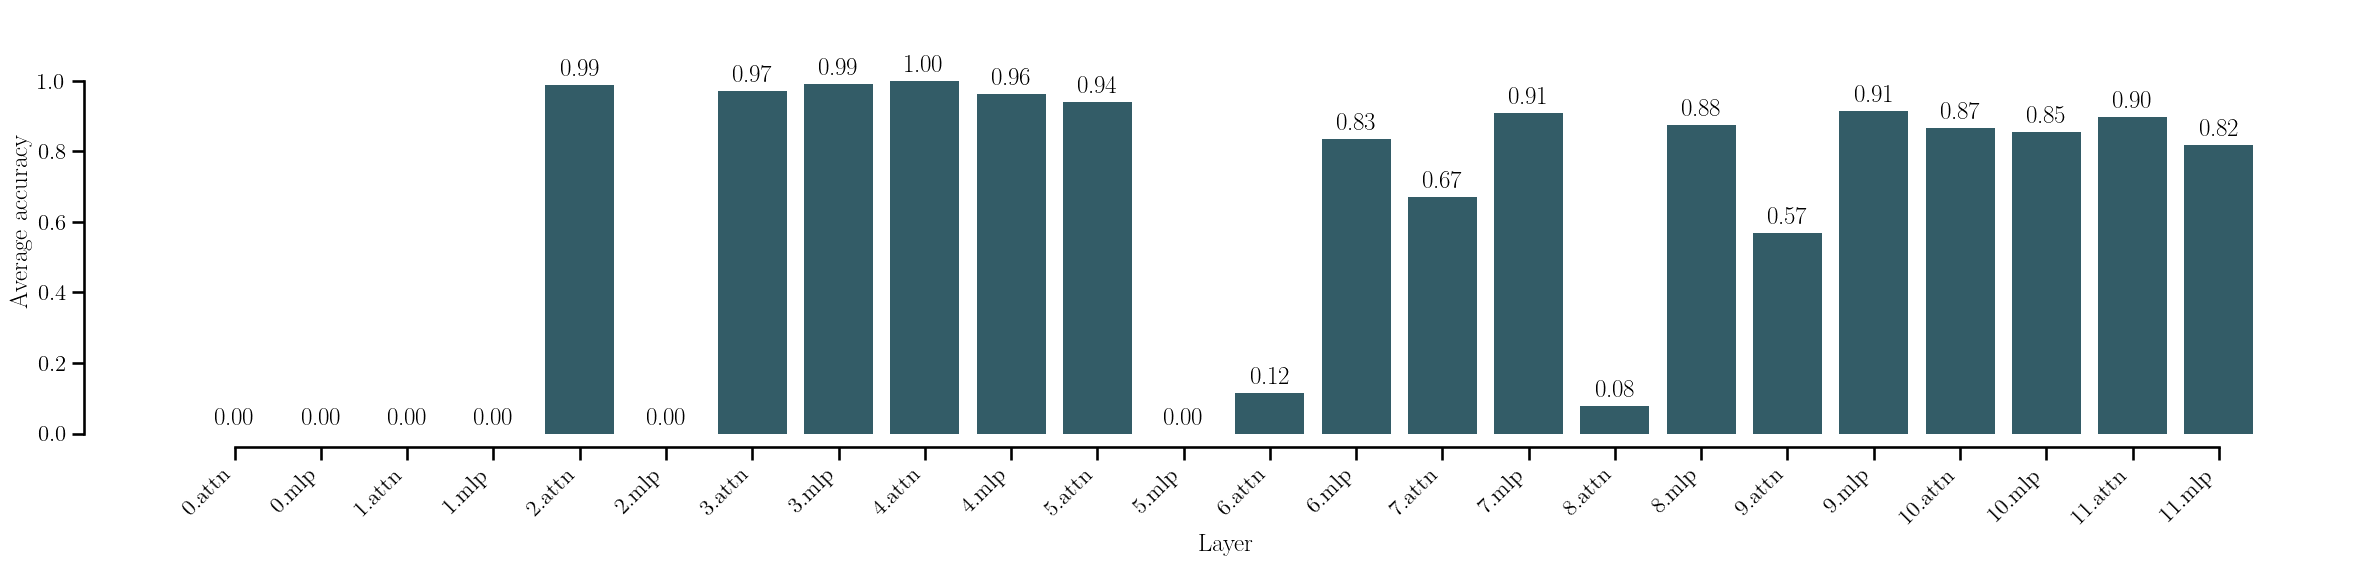

In [15]:
plot_task_accuracies(stl10_accs, layer_names)

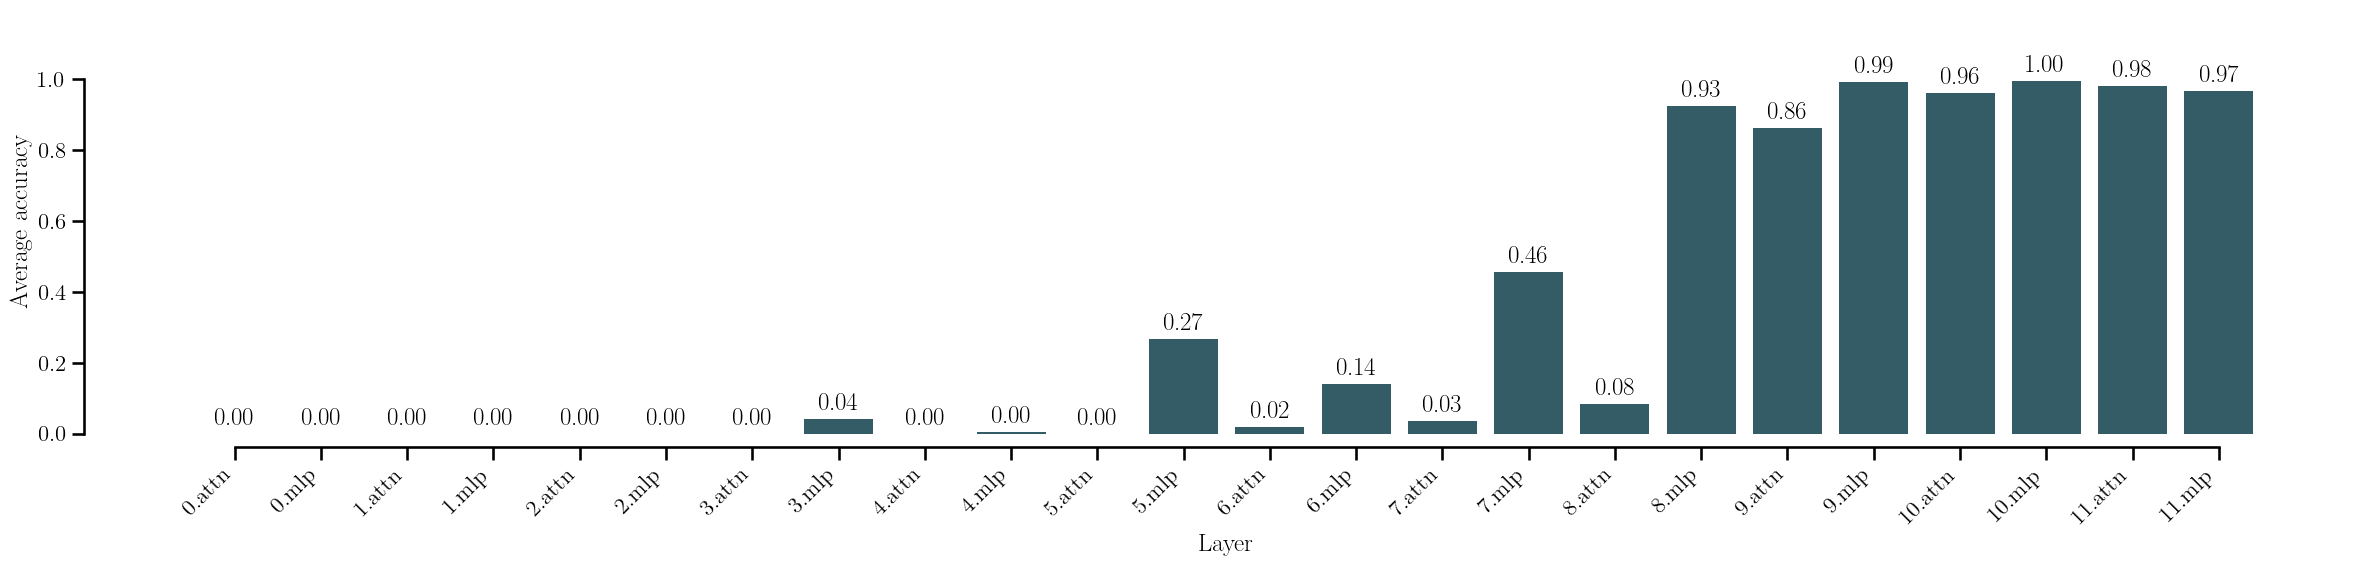

In [17]:
plot_task_accuracies(sun_accs, layer_names)

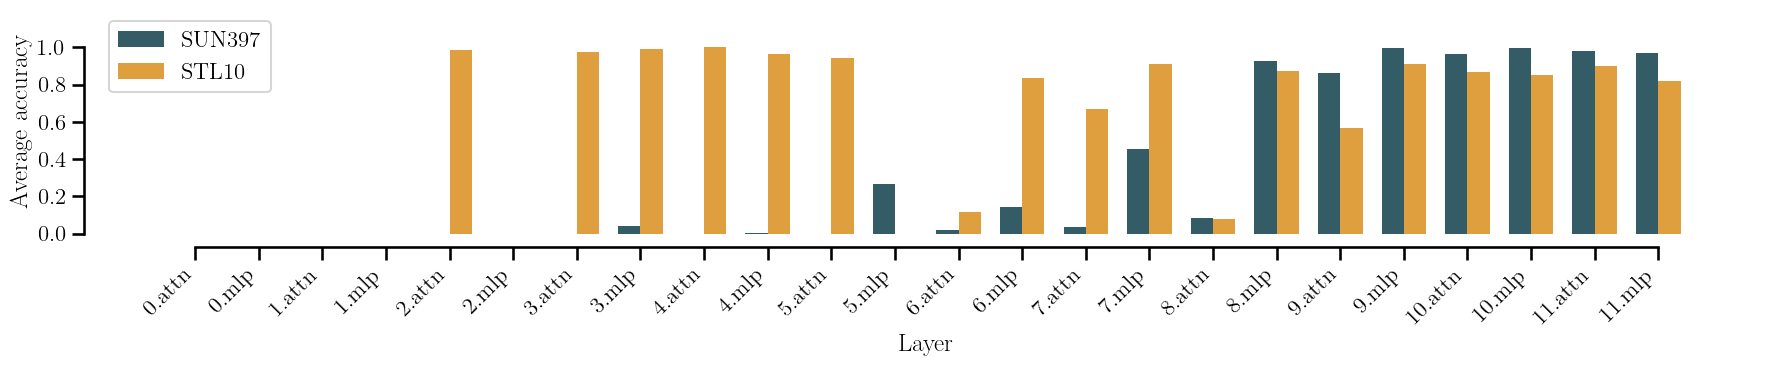

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_two_task_accuracies(layer_accuracies1, layer_accuracies2, label1, label2, layer_names, var1=None, var2=None):
    # x_indices: one group per layer
    x_indices = np.arange(len(layer_accuracies1))
    
    # Set figure width based on model (assumes 'model' and 'palette' are defined globally)
    width = 24 if model == 'ViT-L-14' else 18
    plt.figure(figsize=(width, 4))
    
    bar_width = 0.35  # width of each bar within a group
    
    # Plot first task accuracies shifted left by half the bar width
    if var1 is not None:
        bars1 = plt.bar(x_indices - bar_width/2, layer_accuracies1, bar_width,
                        yerr=var1, color=palette["blue"], capsize=5, ecolor=palette["yellow"], label=label1)
    else:
        bars1 = plt.bar(x_indices - bar_width/2, layer_accuracies1, bar_width,
                        color=palette["blue"], label=label1)
    
    # Plot second task accuracies shifted right by half the bar width
    if var2 is not None:
        bars2 = plt.bar(x_indices + bar_width/2, layer_accuracies2, bar_width,
                        yerr=var2, color=palette["yellow"], capsize=5, ecolor=palette["yellow"], label=label2)
    else:
        bars2 = plt.bar(x_indices + bar_width/2, layer_accuracies2, bar_width,
                        color=palette["yellow"],label=label2)
    
    # Compute a y-limit with some margin based on the maximum accuracy from both tasks
    max_height = max(max(layer_accuracies1), max(layer_accuracies2))
    plt.ylim(0, max_height * 1.2)
    
    # Add numeric labels above each bar
    
    # Remove top and right spines
    sns.despine(offset=10, trim=True)

    ax = plt.gca()
    ax.spines['bottom'].set_bounds(min(x_indices), max(x_indices))

    
    # Set x-axis ticks at group centers with rotated labels
    plt.xticks(x_indices, layer_names, rotation=45, ha="right")
    
    plt.xlabel("Layer")
    plt.ylabel("Average accuracy")
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"figures/{model}_layer_accuracies_two_tasks.pdf")
    plt.show()

model = 'ViT-B-32'

plot_two_task_accuracies(sun_accs, stl10_accs, 'SUN397', 'STL10', layer_names)
